# Machine Learning Engineer Capstone Project
## Binary Classifier

As a jobseeker, it can be confusing to know which roles are most relevant or suitable to ones given skillset, and the process of sifting through job adverts to find the right roles to dedicate time to can be tedious.

Wouldn't it be nice if Data Science and Machine Learning, the source of this confusion, could help tackle this problem?

This project aims to use NLP techniques to build an LSTM classifier to aid in the job hunting process.

The accuracy of the LSTM will be compared to a Dummy classifier, and the McNemar test will be used to evaluate success.

In [1]:
# install wordcloud for exploration phase
!pip install wordcloud

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier

from statsmodels.stats.contingency_tables import mcnemar

import pickle

import os

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import torch
import torch.utils.data
import torch.optim as optim

from train.model1 import LSTMClassifier

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import sagemaker
from sagemaker.pytorch import PyTorch

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [4]:
nltk.download("stopwords", quiet=True)

True

- Data comes from [Kaggle](https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us).

In [5]:
df = pd.read_csv(r"alldata.csv")

We will only be using **position**, used to define the relevance class, and **description**, our feature.

### Exploration

Looking at the first description, we see new line formatting as well as other textual artifacts that need to be removed.

In [61]:
df.description[0]

"Provides administrative support for the creation, coordination, and execution of ongoing well-targeted special events and programs.\n\n\n\nJob Responsibilities\n\nEnsures compliance with all policies, regulations, and laws pertaining to content and use of donor/patient data and IRS regulations.\nCreates financial reports and ensures that event expenses are charged to the appropriate budgets and sub-codes.\nDesigns, fact-checks, and produces event materials including invitations, reply devices, programs and signage. Assists in the preparation of briefings for leadership.\nRecommends and implements procedures for smooth functioning of special events team.\nParticipates in events strategy development. Handles all logistical elements of events, including identifying venues, arranging audio-visual solutions, working closely with venue personnel, caterers, seating arrangements and vendor management.\nWorks with gift officers to compile mailing list parameters to generate appropriate lists f

Here we use a wordcloud to inspect the most common occurances in a given description and across the descriptions.

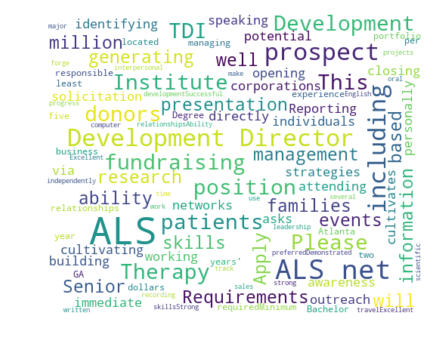

In [6]:
# Start with one review
text = df.description[0]

wordcloud = WordCloud(height=400, width=500, max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

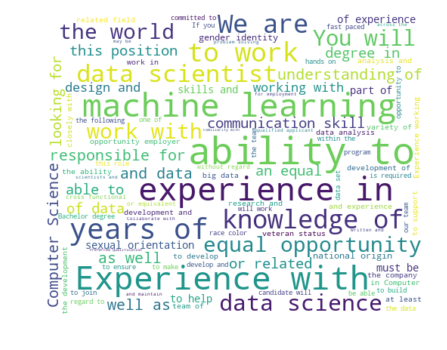

In [7]:
# Start with one review
text = " ".join(str(review) for review in df.description)
wordcloud = WordCloud(height=400, width=500, stopwords=stopwords.words("english"), max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Preprocessing

- Convert position title to lowercase for easier processing

In [8]:
df.position = df.apply(lambda x: str(x.position).lower(), axis=1)

In [9]:
category = [1]
# If the position title contains one of the following (machine|learning|data|scientist|engineer|develop), classify it as relevant
condition = [df.position.str.contains("machine|learning|data|scientist|engineer|develop")]
df["category"] = np.select(condition, category, default=0)

- Resample to remove imbalance in dataset

Initial attempts found that the unbalanced dataset had a large detrimental effect on accuracy, particularly for the multiclass case.

In [10]:
li = []
for category in df.category.unique():
    li.append(df[df.category==category].sample(n=2200, replace=True))
df = pd.concat(li)

- Shuffle the data after resampling

In [11]:
df = df.sample(frac=1).reset_index(drop=True)

- Create train/test/validation sets

In [12]:
train_X, test_X, train_y, test_y = train_test_split(
    df.description, df.category, test_size=0.2, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.25, random_state=1)

- Function to create bag-of-words from text

In [13]:
def bow(text):
    text = str(text)
    stemmer = PorterStemmer()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

- Convert train/test/validation sets to bag-of-words using the above function. Cache to avoid repeat preprocess.

In [14]:
cache_dir = os.path.join(r"cache", "preprocessed")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, data_val, labels_train, labels_test, labels_val,
                    cache_dir=cache_dir, cache_file="preprocessed_data1.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [bow(text) for text in data_train]
        words_test = [bow(text) for text in data_test]
        words_val = [bow(text) for text in data_val]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test, words_val=words_val,
                              labels_train=labels_train, labels_test=labels_test, labels_val=labels_val)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, words_val, labels_train, labels_test, labels_val = (cache_data['words_train'],
                cache_data['words_test'], cache_data['words_val'], cache_data['labels_train'], cache_data['labels_test'], cache_data['labels_val'])
    
    return words_train, words_test, words_val, labels_train, labels_test, labels_val

In [15]:
%%time

# Preprocess data
train_X, test_X, val_X, train_y, test_y, val_y = preprocess_data(train_X, test_X, val_X, train_y, test_y, val_y)

Read preprocessed data from cache file: preprocessed_data1.pkl
CPU times: user 247 ms, sys: 66.8 ms, total: 314 ms
Wall time: 255 ms


- Build vocabulary used to vectorise bag-of-words

In [16]:
def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    word_count = {} 

    for review in data:
        for word in review:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    sorted_words = [word for word, count in sorted(word_count.items(), key=lambda x:x[1], reverse=True)]

    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [17]:
word_dict = build_dict(train_X)

- For fun, lets look at the word cloud for our vocabulary. This appears to give much more insight into the typical parlance found in the descriptions.

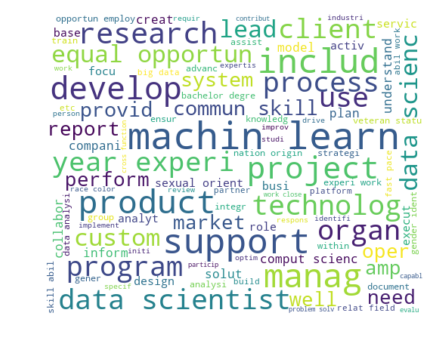

In [18]:
text = " ".join(t for t in [j for sub in train_X for j in sub])
wordcloud = WordCloud(height=400, width=500, stopwords=stopwords.words("english"), max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Save the data

In [19]:
data_dir = r'data/' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [20]:
with open(os.path.join(data_dir, 'word_dict1.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [21]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict

    working_sentence = [NOWORD] * pad

    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ

    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []

    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)

    return np.array(result), np.array(lengths)

In [22]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)
val_X, val_X_len = convert_and_pad_data(word_dict, val_X)

In [23]:
pd.concat([train_y.reset_index(drop=True), pd.DataFrame(train_X_len, columns=['Length']), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train1.csv'), header=False, index=False)

In [24]:
pd.concat([test_y.reset_index(drop=True), pd.DataFrame(test_X_len, columns=['Length']), pd.DataFrame(test_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'test1.csv'), header=False, index=False)

In [25]:
pd.concat([val_y.reset_index(drop=True), pd.DataFrame(val_X_len, columns=['Length']), pd.DataFrame(val_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'val1.csv'), header=False, index=False)

In [26]:
!pygmentize train/model1.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=0.2)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        re

### Train LSTM and Dummy

The LSTM uses a similar structure to the one used earlier in the course. I've added a validation set. The results of this will be discussed shortly.

In [27]:
# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train1.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

In [28]:
# Read in only the first 250 rows
val_sample = pd.read_csv(os.path.join(data_dir, 'val1.csv'), header=None, names=None, nrows=50)

# Turn the input pandas dataframe into tensors
val_sample_y = torch.from_numpy(val_sample[[0]].values).float().squeeze()
val_sample_X = torch.from_numpy(val_sample.drop([0], axis=1).values).long()

# Build the dataset
val_sample_ds = torch.utils.data.TensorDataset(val_sample_X, val_sample_y)
# Build the dataloader
val_sample_dl = torch.utils.data.DataLoader(val_sample_ds, batch_size=10)

In [29]:
def train(model, train_loader, epochs, optimizer, loss_fn, device, valid_loader=None):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        print("Epoch: {}".format(epoch))
        for batch in train_loader:         
            batch_X, batch_y = batch
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            # forward propagate
            out = model(batch_X)

            loss = loss_fn(out, batch_y)

            # backwards propagate
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("BCELoss: {}".format(total_loss / len(train_loader)))
        if valid_loader:
            model.eval()
            val_loss = 0.0
            #val_preds = np.zeros((len(x_cv),len(le.classes_)))

            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()
                val_loss += loss_fn(y_pred, y_batch).item()
                # keep/store predictions
                #val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()

            # Check Accuracy
            #val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
            print("ValLoss: {}".format(val_loss/len(valid_loader)))

In [71]:
dum = DummyClassifier(strategy="stratified")
dum.fit(train_sample.iloc[:,1:], train_sample.iloc[:,0])
print("Dummy Classifier Accuracy: {}".format(dum.score(test_X, test_y)))

Dummy Classifier Accuracy: 0.48409090909090907


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [73]:
# Compare on untrained LSTM
print("Training Accuracy:", accuracy_score(np.round(model(train_sample_X).detach().numpy()),np.array(train_sample_y)))
test = torch.from_numpy(pd.concat([pd.DataFrame(test_X_len, columns=['Length']), pd.DataFrame(test_X)], axis=1).values).long()
print("Test Accuracy:", accuracy_score(np.round(model(test).detach().numpy()),np.array(test_y)))
print("Confusion Matrix")
confusion_matrix(np.round(model(test).detach().numpy()),np.array(test_y))

Training Accuracy: 0.512
Test Accuracy: 0.5045454545454545
Confusion Matrix


array([[190, 168],
       [268, 254]])

In [74]:
train(model, train_sample_dl, 10, optimizer, loss_fn, device, val_sample_dl)

Epoch: 1
BCELoss: 0.6880254745483398
ValLoss: 0.6557303547859192
Epoch: 2
BCELoss: 0.5732981562614441
ValLoss: 0.6510188698768615
Epoch: 3
BCELoss: 0.48475380539894103
ValLoss: 0.6817474246025086
Epoch: 4
BCELoss: 0.3841717720031738
ValLoss: 0.7492096543312072
Epoch: 5
BCELoss: 0.2710018426179886
ValLoss: 0.9106303572654724
Epoch: 6
BCELoss: 0.1614290654659271
ValLoss: 1.0283777475357057
Epoch: 7
BCELoss: 0.11097769364714623
ValLoss: 1.3686655402183532
Epoch: 8
BCELoss: 0.07878433167934418
ValLoss: 1.4789478778839111
Epoch: 9
BCELoss: 0.05761447660624981
ValLoss: 1.4191815972328186
Epoch: 10
BCELoss: 0.05291481763124466
ValLoss: 1.5096137046813964


As we can see, the validation loss actually becomes quite a bit worse. It is likely the model is overfitting and could benefit from regularization or dropout.

In [75]:
print("Training Accuracy:", accuracy_score(np.round(model(train_sample_X).detach().numpy()),np.array(train_sample_y)))
test = torch.from_numpy(pd.concat([pd.DataFrame(test_X_len, columns=['Length']), pd.DataFrame(test_X)], axis=1).values).long()
print("Test Accuracy:", accuracy_score(np.round(model(test).detach().numpy()),np.array(test_y)))
confusion_matrix(np.round(model(test).detach().numpy()),np.array(test_y))

Training Accuracy: 0.98
Test Accuracy: 0.5556818181818182


array([[229, 162],
       [229, 260]])

The model does improve compared to our benchmark, though this is rather unstable. Subsequent runs can have large swings in accuracy.

### Deploy Endpoint

Here we deploy and test our sagemaker model using McNemar's test

In [40]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/JobSingleClassLSTM'

role = sagemaker.get_execution_role()

In [41]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [42]:
estimator = PyTorch(entry_point="train1.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 100,
                        'learning_rate': 0.01
                    })

In [43]:
estimator.fit({'training': input_data})

2020-06-16 20:49:16 Starting - Starting the training job...
2020-06-16 20:49:19 Starting - Launching requested ML instances.........
2020-06-16 20:50:49 Starting - Preparing the instances for training...
2020-06-16 20:51:32 Downloading - Downloading input data...
2020-06-16 20:52:15 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-16 20:52:16,366 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-16 20:52:16,369 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-16 20:52:16,382 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-16 20:52:22,604 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-16 20:52:22,814 sagemaker-containers INFO     Module train1 does not provide a setup.py. 
Generating set

In [44]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

In [45]:
test = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [46]:
predictions = np.round(predictor.predict(test))

In [47]:
accuracy_score(test_y, predictions)

0.7045454545454546

In [48]:
confusion_matrix(test_y, predictions)

array([[315, 143],
       [117, 305]])

In [49]:
predictor.delete_endpoint()

### McNemar

In [53]:
test_outcomes = pd.DataFrame({"Dummy":dum.predict(test_X)==test_y, "LSTM":predictions==test_y})

In [54]:
contingency = pd.crosstab(test_outcomes.Dummy, test_outcomes.LSTM)

In [55]:
stats = mcnemar(contingency, exact=False, correction=True)

In [59]:
print('statistic=%.2f, p-value=%.5f' % (stats.statistic, stats.pvalue))

statistic=76.98, p-value=0.00000


In [57]:
alpha = 0.05
if stats.pvalue > alpha:
    print('Fail to reject Null Hypothesis')
else:
    print('Statistically significant difference, reject Null Hypothesis')

Statistically significant difference, reject Null Hypothesis
